In [1]:
# install packages
!pip install networkx mido pretty_midi fluidsynth

import torch
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch_geometric
from torch_scatter import scatter_mean, scatter_max, scatter_sum
from torch_geometric.utils.convert import from_scipy_sparse_matrix

import mido
import pretty_midi
from scipy.io.wavfile import write

# For converting midi into wav files
!apt-get install fluidsynth
import fluidsynth

import numpy as np
import random

#for nice visualisations
import networkx as nx
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-1.13.1+cu116.html
Reading package lists... Done
Building dependency tree       
Reading state information... Done
fluidsynth is already the newest version (2.1.1-2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


# Helper functions

## MIDI processing functions

In [2]:
def get_midi_timesteps(filename):
    midi = mido.MidiFile(filename)
    timesteps = 0
    for track in midi.tracks:
        for msg in track:
            timesteps += msg.time
    return timesteps

def midi_to_tensor(filename, binary_velocity=False):
    mid = mido.MidiFile(filename)
    # Extract information about the notes being played
    max_timesteps = get_midi_timesteps(filename)
    tensor = np.zeros((max_timesteps, 128))
    previous_note = [0] * 128
    timesteps = 0
    for track in mid.tracks:
        for msg in track:
            timesteps += msg.time
            if msg.type == 'note_on':
                tmp = previous_note[msg.note]
                tensor[tmp:timesteps, msg.note] = tensor[tmp, msg.note]
                if binary_velocity:
                  tensor[timesteps, msg.note] = 1 if msg.velocity > 0 else 0
                else:
                  tensor[timesteps, msg.note] = msg.velocity
                previous_note[msg.note] = timesteps
            if msg.type == 'note_off':
                tmp = previous_note[msg.note]
                tensor[tmp:timesteps, msg.note] = tensor[tmp, msg.note]
                tensor[timesteps, msg.note] = 0
                previous_note[msg.note] = timesteps
    return torch.from_numpy(tensor)

def arry2mid(ary, tempo=500000):
    new_ary = np.concatenate([np.array([[0] * 128]), np.array(ary)], axis=0)
    mid_new = mido.MidiFile()
    track = mido.MidiTrack()
    mid_new.tracks.append(track)
    track.append(mido.MetaMessage('set_tempo', tempo=tempo, time=0))
    changes = new_ary[1:] - new_ary[:-1]
    last_time = 0
    for ch in changes:
        if sum(ch) == 0:  # no change
            last_time += 1
        else:
            on_notes = np.where(ch > 0)[0]
            on_notes_velocity = ch[on_notes]
            off_notes = np.where(ch < 0)[0]
            first_ = True
            for n, v in zip(on_notes, on_notes_velocity):
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_on', note=int(n), velocity=int(v), time=int(new_time)))
                first_ = False
            for n in off_notes:
                new_time = last_time if first_ else 0
                track.append(mido.Message('note_off', note=int(n), velocity=0, time=int(new_time)))
                first_ = False
            last_time = 0
    return mid_new

## Tonnetz Adjancy matrix generating function

In [3]:
# In Tonnetz, each node has six neighbours which have pitches of the following distances (in semi-tones)
# E.g. C4 has neighbours F3, G#3, A3, D#4, E4, G4
NEIGHBOUR_DISTANCES = [-7, -4, -3, 3, 4, 7]

def create_tonnetz_adjacency_matrix(num_notes):
  A = []

  for i in range(num_notes):
    row = torch.zeros(num_notes, dtype=torch.int)
    for d in NEIGHBOUR_DISTANCES:
      j = i+d
      if j >= 0 and j < num_notes:
        row[j] = 1
    A.append(row)
  return torch.stack(A)

def get_edge_attributes(A):
  # Returns edge attributes for the adjacency matrix `A`, 
  # where the edge attributes are a one-hot encoding for each type of edge
  edge_index = A.to_sparse().indices()
  edge_attr_raw = []
  for i in range(edge_index.shape[1]):
    distance = (edge_index[1][i] - edge_index[0][i]).item()
    edge_attr_raw.append(NEIGHBOUR_DISTANCES.index(distance))
  return F.one_hot(torch.tensor(edge_attr_raw))

## Data processing helper function

In [4]:
import math, logging

desired_tpb = 8

def calculate_compress_factor(file_name, desired_tpb):
  mid = mido.MidiFile(file_name)
  compress_factor = mid.ticks_per_beat / desired_tpb
  if compress_factor % 1.0 != 0.0:
    logging.warning(f"compress_factor of {compress_factor} is not an integer, rounding up...")
  compress_factor = math.ceil(compress_factor)
  return compress_factor

def compress_tensor(tensor, file_name, method, desired_tpb=16):
  '''
  Reduces the fidelity of the musical tensor, i.e. merge multiple timesteps into one step

  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `file_name`: path to the MIDI file
    `method`: str in ["max", "avg", "majority"]
    `desired_tpb`: desired ticks per beat for the tensor to be compressed to
  '''
  tensor_np = tensor.cpu().detach().cpu()
  assert(len(tensor_np.shape) == 2)

  compress_factor = calculate_compress_factor(file_name, desired_tpb)
  compressed_vectors = []
  length = tensor_np.shape[0]
  for start in range(0, length, compress_factor):
    end = min(start + compress_factor, length)
    tensor_slice = tensor_np[start:end, :]
    if (method == "max"):
      raise NotImplementedError()
    elif (method == "avg"):
      raise NotImplementedError()
    elif (method == "majority"):
      majority = (end-start) / 2
      majority_nonzeroes = np.count_nonzero(tensor_slice, axis=0) >= majority
      compressed_vectors.append((majority_nonzeroes).astype(int))
    else:
      raise KeyError(f"Unknown method {method}")
  return torch.tensor(np.array(compressed_vectors))

def reduce_tensor(tensor, start_note, end_note):
  '''
  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `start_note`: note to start the tensor from (integer in 0-127)
    `end_note`: note to end the tensor at (integer in 0-127)
  '''
  assert(end_note >= start_note)
  return tensor[:, start_note:end_note+1]

def uncompress_tensor(tensor, orig_tpb, compressed_tpb):
  '''
  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `orig_tpb`: ticks per beat of the original/generated MIDI file
    `compressed_tpb`: ticks per beat used by the compressed `tensor`
  '''
  compress_factor = orig_tpb / compressed_tpb
  if compress_factor % 1.0 != 0.0:
    logging.warning(f"compress_factor of {compress_factor} is not an integer, rounding up...")
  compress_factor = math.ceil(compress_factor)
  # "Stretch" out the tensor using Kronecker product
  return torch.kron(tensor, torch.ones((compress_factor, 1)))

def unreduce_tensor(tensor, start_note, end_note):
  '''
  Expands out a reduced tensor to include all 128 notes in the MIDI range

  Args:
    `tensor`: PyTorch tensor of shape (timesteps, num_notes)
    `start_note`: MIDI note that `tensor` starts from (integer in 0-127)
    `end_note`: MIDI note that `tensor` ends at (integer in 0-127)
  '''
  assert(end_note >= start_note)
  timesteps = tensor.shape[0]
  low_notes = torch.zeros((timesteps, start_note))
  high_notes = torch.zeros((timesteps, 127-end_note))
  return torch.cat((low_notes, tensor, high_notes), dim=1)

In [5]:
# function which takes music sequence and window size(history length) and return training data.
# music = Time_step x Num_nodes
def slice_temporal_data(music_seq,window_size=5):
  return [[torch.transpose(music_seq[i:i+window_size],0,1),music_seq[i+window_size].reshape(-1,1)] for i in range(len(music_seq)-window_size)]

# Data loading

In [6]:
# Download and extract piano MIDI files from Maestro
!wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip

import os
import zipfile

directory_to_extract_to = "maestro"
with zipfile.ZipFile("maestro-v3.0.0-midi.zip", 'r') as zip_ref:
    zip_ref.extractall(directory_to_extract_to)

dir_to_scan = directory_to_extract_to + "/maestro-v3.0.0/2013"
directory_files = os.listdir(dir_to_scan)
data_files = []
for file in directory_files:
  data_files.append(os.path.join(dir_to_scan, file))

--2023-03-20 04:41:58--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.127.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.127.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip.3’

maestro-v3.0.0-midi 100%[===================>]  55.71M  28.5MB/s    in 2.0s    

2023-03-20 04:42:00 (28.5 MB/s) - ‘maestro-v3.0.0-midi.zip.3’ saved [58416533/58416533]



In [7]:
num_files = 10
window_size = desired_tpb * 4
start_note = 33
end_note = 96

train_data = []
for i, data_file in enumerate(data_files):
  midi_tensor = midi_to_tensor(data_file, binary_velocity=True)
  compressed_tensor = compress_tensor(midi_tensor, data_file, "majority", desired_tpb)
  reduced_tensor = reduce_tensor(compressed_tensor, start_note, end_note)
  train_data += slice_temporal_data(reduced_tensor.to(torch.float), window_size)
  if i == num_files:
    break
print(len(train_data), train_data[0][0].shape, train_data[0][1].shape)

48649 torch.Size([64, 32]) torch.Size([64, 1])


# Prepare model trainig 

## create graph representation

In [8]:
new_num_notes = train_data[0][0].shape[0]
A = create_tonnetz_adjacency_matrix(new_num_notes)
edge_attr = get_edge_attributes(A)
print(A.shape)
print(edge_attr.shape)

torch.Size([64, 64])
torch.Size([356, 6])


## create data loader

In [39]:
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

data_X = torch.stack([d[0] for d in train_data])
print(data_X.shape)
y = torch.stack([d[1] for d in train_data])
data_Y = y.squeeze(-1)
print(data_Y.shape)
X_train, X_test, y_train, y_test = train_test_split(data_X.to(torch.float), data_Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_test, y_test)

batch_size = 1
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

torch.Size([48649, 64, 32])
torch.Size([48649, 64])
torch.Size([38919, 64, 32])
torch.Size([38919, 64])


## train and eval helper function

In [41]:
def train_eval(net, device, criterion, optimizer, epoch, train_dataloader, valid_dataloader=None, epochs_to_report=10):
  '''
  `epochs_to_report`: the number of epochs before reporting progress
  '''
  train_loss_list = []
  train_acc_list = []
  test_loss_list = []
  test_acc_list = []

  for i in range(epoch):
      report_progress = (i+1) % epochs_to_report == 0
      if report_progress:
        print("\n------------------------------------------------------")
        print("Epoch {}/{}".format(i+1,epoch))
      
      train_loss = 0
      train_acc = 0
      test_loss = 0
      test_acc = 0
      
      net.train()
      for data,label in train_dataloader:
          data = data.to(device)
          label = label.to(device)
          optimizer.zero_grad()
          y_pred_prob = net(data[0])
          #y_pred_prob = net(data)
          y_pred_prob = y_pred_prob.reshape(1,-1)
          #print(y_pred_prob.shape)
          #print(label.shape)
          loss = criterion(y_pred_prob,label)
          loss.backward()
          optimizer.step()
          train_loss += loss.item()
          y_pred = torch.round(torch.sigmoid(y_pred_prob))
          train_acc += torch.count_nonzero(torch.all(torch.eq(label, y_pred), dim=1)).item() / len(label)
      batch_train_loss = train_loss/len(train_dataloader)
      batch_train_acc = train_acc/len(train_dataloader)
      train_loss_list.append(batch_train_loss)
      train_acc_list.append(batch_train_acc)
      if report_progress:
        print("Train_Loss: {:.4f} Train_Acc: {:.4f}".format(batch_train_loss, batch_train_acc))
      
      if valid_dataloader is not None:
        net.eval()
        with torch.no_grad():
            for data,label in valid_dataloader:
                data = data.to(device)
                label = label.to(device)
                y_pred_prob = net(data[0])
                y_pred_prob = y_pred_prob.reshape(1,-1)
                loss = criterion(y_pred_prob,label)
                test_loss += loss.item()
                y_pred = torch.round(torch.sigmoid(y_pred_prob))
                test_acc += torch.count_nonzero(torch.all(torch.eq(label, y_pred), dim=1)).item() / len(label)
        batch_test_loss = test_loss/len(valid_dataloader)
        batch_test_acc = test_acc/len(valid_dataloader)
        test_loss_list.append(batch_test_loss)
        test_acc_list.append(batch_test_acc)
        if report_progress:
          print("Test_Loss: {:.4f} Test_Acc: {:.4f}".format(batch_test_loss,batch_test_acc))
  return train_loss_list, test_loss_list, train_acc_list, test_acc_list

def plot(epoch,train_loss_list, test_loss_list, train_acc_list, test_acc_list):
  # visualizing training process
  plt.figure()
  plt.title("Train and Test Loss")
  plt.xlabel("epoch")
  plt.ylabel("loss")
  plt.plot(range(1,epoch+1),train_loss_list,color="b",linestyle="-",label="train_loss")
  if valid_dataloader is not None:
    plt.plot(range(1,epoch+1),test_loss_list,color="r",linestyle="--",label="test_loss")
  plt.legend()
  plt.figure()
  plt.title("Train and Test Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("accuracy")
  plt.plot(range(1,epoch+1),train_acc_list,color="b",linestyle="-",label="train_accuracy")
  if valid_dataloader is not None:
    plt.plot(range(1,epoch+1),test_acc_list,color="r",linestyle="--",label="test_accuracy")
  plt.legend()
  plt.show()

# Define the model

Refers https://sladewinter.medium.com/video-frame-prediction-using-convlstm-network-in-pytorch-b5210a6ce582

In [11]:
! pip install torch-geometric-temporal

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [12]:
from torch.nn import Linear, ReLU, BatchNorm1d, Module, Sequential
from torch_geometric.nn import GCNConv, MessagePassing
from torch_geometric_temporal.nn.recurrent import GConvLSTM
from torch_scatter import scatter

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is ",device)

Device is  cpu


## model definition

In [36]:
class SimpleSTGCN(nn.Module):
    # input_dim = dim of node features
    # output_dim = number of class which is ON/OFF
    def __init__(self, adj_mat, edge_attrs, input_dim, hidden_dim=16, output_dim=2):
        super(SimpleSTGCN, self).__init__()
        self.adj_mat = adj_mat
        self.edge_index = self.adj_mat.to_sparse().indices().to(device)
        self.edge_weight = edge_attrs.to(device).to(float)
        
        # GCN layers
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.gcn_conv1 = GConvLSTM(hidden_dim,hidden_dim,K=2)   # K=2 for 2-degree convolution (neighbor convolution)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim)
        self.linear4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        #print(x.shape)
        h,c = self.gcn_conv1(x,self.edge_index)
        #print(h.shape, c.shape)
        x = F.relu(self.linear3(h))
        x = self.linear4(x)
        y_hat = x.squeeze(-1)
        return y_hat

In [21]:
gcn_conv1 = GConvLSTM(32,16,K=2)
edge_index = A.to_sparse().indices()
#print(edge_index)
for x,y in train_dataloader:
  print(x[0].shape)
  h,c = gcn_conv1(x[0],edge_index)
  print(h.shape,c.shape)
  break

torch.Size([64, 32])
torch.Size([64, 16]) torch.Size([64, 16])


# Training

In [42]:
net = SimpleSTGCN(A, edge_attr, window_size, output_dim=1).to(device)
pos_weight = torch.ones([new_num_notes]) * 5
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = torch.optim.Adam(net.parameters(), lr=0.005)
epoch = 10

trainL,testL,trainA,testA = train_eval(net, device, criterion, optimizer, epoch, train_dataloader, valid_dataloader, epochs_to_report=1)


------------------------------------------------------
Epoch 1/10
Train_Loss: 0.1945 Train_Acc: 0.3823
Test_Loss: 0.1947 Test_Acc: 0.3902

------------------------------------------------------
Epoch 2/10
Train_Loss: 0.1903 Train_Acc: 0.3867
Test_Loss: 0.1909 Test_Acc: 0.3962

------------------------------------------------------
Epoch 3/10
Train_Loss: 0.1903 Train_Acc: 0.3875
Test_Loss: 0.1914 Test_Acc: 0.3963

------------------------------------------------------
Epoch 4/10
Train_Loss: 0.1910 Train_Acc: 0.3843
Test_Loss: 0.1967 Test_Acc: 0.3809

------------------------------------------------------
Epoch 5/10
Train_Loss: 0.1908 Train_Acc: 0.3879
Test_Loss: 0.1951 Test_Acc: 0.3956

------------------------------------------------------
Epoch 6/10
Train_Loss: 0.1940 Train_Acc: 0.3871
Test_Loss: 0.1953 Test_Acc: 0.3923

------------------------------------------------------
Epoch 7/10
Train_Loss: 0.1977 Train_Acc: 0.3847
Test_Loss: 0.2038 Test_Acc: 0.3946

--------------------------

In [43]:
torch.save(net.state_dict(),"GConvLSTM_epoch10_acc_0.38.net")

# Create music

In [47]:
def generate_music_tensor(net, seed, timesteps):
  generated = seed
  window_size = seed.shape[1]
  for i in range(timesteps):
    if i == 0:
      pred = net(seed)
    else:
      pred = net(generated[:, -window_size:])
    curr = (torch.sigmoid(pred) > 0.5).float()
    generated = torch.cat((generated, curr.unsqueeze(1)), dim=1)
  return generated

def create_music(model, seed, new_timesteps, start_note, end_note, orig_tpb, compressed_tpb):
  generated_tensor = generate_music_tensor(model, seed, new_timesteps).to("cpu")
  generated_tensor_mod = unreduce_tensor(torch.transpose(generated_tensor, 0, 1), start_note, end_note)
  generated_tensor_mod = uncompress_tensor(generated_tensor_mod, orig_tpb, compressed_tpb)
  return generated_tensor_mod

In [46]:
new_timesteps = 256
orig_tpb = 384
compressed_tpb = desired_tpb

net2 = SimpleSTGCN(A, edge_attr, window_size, output_dim=1)
net2.load_state_dict(torch.load("GConvLSTM_epoch10_acc_0.38.net"))
net2 = net2.to(device)

torch.Size([13824, 128])


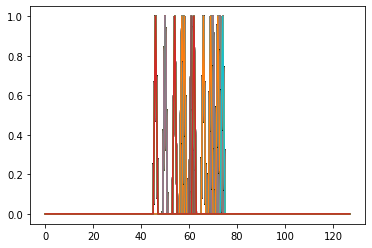

In [48]:
data, _ = next(iter(valid_dataloader))
seed = data[0].to(device)
generated = create_music(net2, seed, new_timesteps, start_note, end_note, orig_tpb, compressed_tpb)
print(generated.shape)
plt.plot(torch.transpose(generated, 0, 1).cpu().detach().numpy())
plt.show()

In [49]:
arr = generated.cpu().detach().numpy()
mid = arry2mid(arr)
mid.save("sample_music_GConvLSTM_acc_0.38.midi")

## Piano roll view

In [50]:
def piano_roll(array,plot_range = (0,3000)):
    array = array[plot_range[0]:plot_range[1]]
    plt.plot(range(array.shape[0]), np.multiply(np.where(array>0, 1, 0), range(1, 129)), marker='.', markersize=1, linestyle='')
    plt.title("Piano roll")
    plt.xlabel("Timessteps")
    plt.ylabel("Notes")
    plt.show()

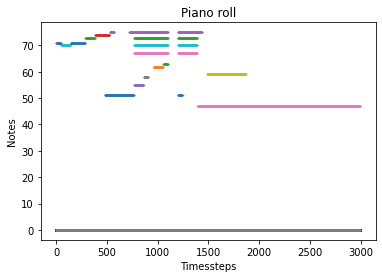

In [51]:
piano_roll(arr)